SIP Project

Topic - YOLO (You Only Look Once) implementation on denoised/filtered images



---


Made by:

Aditya Katariya - I026

Importing Necessary libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

**IMAGE PROCESSING**

Reading the image

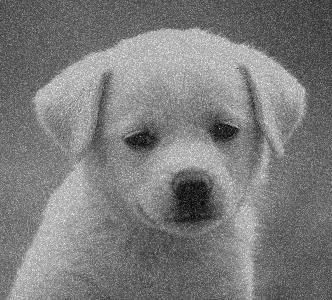

Original Image


In [ ]:
img = cv2.imread('/content/drive/MyDrive/SIP_Project/phpMicl7E.png',0)
cv2_imshow(img)
print("Original Image")

In [ ]:
m,n = img.shape
print(m,n)

300 332


Histogram Equalization for image enhancement

1. Compute the histogram of the image.

2. Compute the CDF of the histogram.

3. Map each pixel value in the image to its corresponding value in the CDF.

4. Normalize the pixel values to the full dynamic range of the image.

In [ ]:
def histoNew(og):
    r = np.arange(0, 256, dtype=int)
    count = np.zeros(len(r), dtype=int)
    for k in r:
        count[k] = (og==k).sum()
    return(r, count)

r, nk = histoNew(img)

In [ ]:
pdf = nk/(m*n)
pdf1 = pdf.copy()
cdf = np.array(np.zeros(len(pdf)))
cdf[0] = pdf[0]

for i in range(1, len(pdf)):
    cdf[i] = cdf[i-1]+pdf1[i]

sk = cdf*255
sk = sk.astype(int)

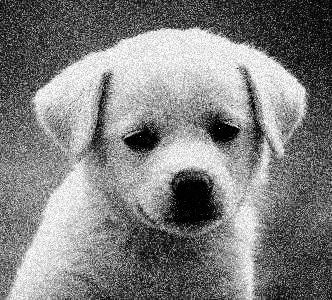

Equalized Image


In [ ]:
imgEqu = np.zeros((m, n), dtype=int)
for i in range(m):
    for j in range(n):
        temp = img[i, j]
        imgEqu[i,j] = sk[temp]
imgEqu = imgEqu.astype(int)

cv2_imshow(imgEqu)
print("Equalized Image")

Weiner filter

The Wiener filter uses both the noisy signal and a model of the underlying clean signal to estimate the optimal linear filter for removing the noise.

 The filter is designed to minimize the mean square error between the filtered signal and the clean signal.

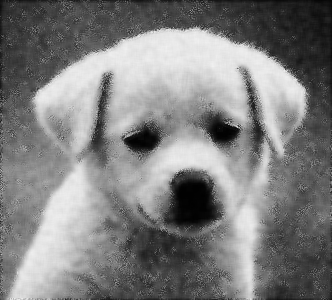

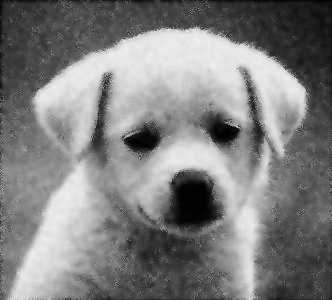

In [ ]:
from scipy.signal import wiener

img1 = imgEqu.copy()

# Use the Wiener filter to perform denoising
dc = wiener(img1, mysize=6)
cv2_imshow(dc)

img2 = img.copy()

#Adding noise to the image
#noise1 = 0.1 * np.random.standard_normal(img2.shape)
#noisy_img1 = img2 + noise

#Using the Wiener filter to perform denoising
dc1 = wiener(img2, mysize=2)
cv2_imshow(dc1)

Median Filter

The median filter considers each pixel in the image in turn and looks at its nearby neighbors to decide whether or not it is representative of its surroundings.

Instead of simply replacing the pixel value with the mean of neighboring pixel values, it replaces it with the median of those values.

The median is calculated by first sorting all the pixel values from the surrounding neighborhood into numerical order and then replacing the pixel being considered with the middle pixel value. (If the neighborhood under consideration contains an even number of pixels, the average of the two middle pixel values is used.)


Enter value of mask: 3


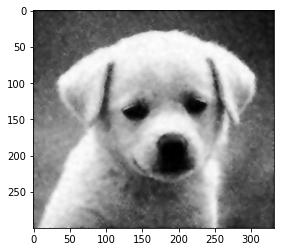

In [ ]:
B=int(input("Enter value of mask: ")) #Taking the value of the mask as input
img_mf=img.copy()
A=B//2

for i in range(A,m-A):
  for j in range(A,n-A):
    temp=dc[i-A:i+A+1,j-A:j+A+1]
    img_mf[i,j]=np.median(temp)
plt.imshow(img_mf,cmap='gray')

Plotting the images for comparison

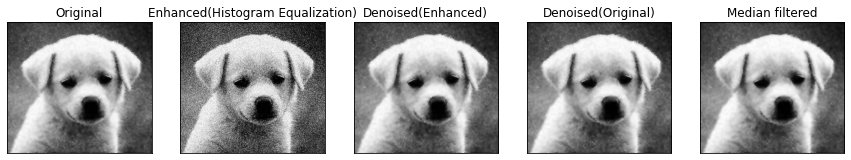

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
ax[1].imshow(imgEqu, cmap='gray')
ax[1].set_title('Enhanced(Histogram Equalization)')
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
ax[2].imshow(dc, cmap='gray')
ax[2].set_title('Denoised(Enhanced)')
ax[3].imshow(dc1, cmap='gray')
ax[3].set_title('Denoised(Original)')
ax[4].imshow(img_mf, cmap='gray')
ax[4].set_title('Median filtered')
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.show()

Changing the number of input channels

In [ ]:
imgp=imgEqu.copy()
#Add a channel dimension to the image
input_img = np.expand_dims(imgp, axis=-1)

#Scale the image to the range [0, 1]
input_img = input_img.astype("float32") / 255.0

img_rgb = cv2.cvtColor(input_img, cv2.COLOR_GRAY2RGB)
img_rgb.shape


(300, 332, 3)

**MACHINE LEARNING**

YOLO (You Only Look Once)

Prior detection systems repurpose classifiers or localizers to perform detection.

 They apply the model to an image at multiple locations and scales.

  High scoring regions of the image are considered detections.

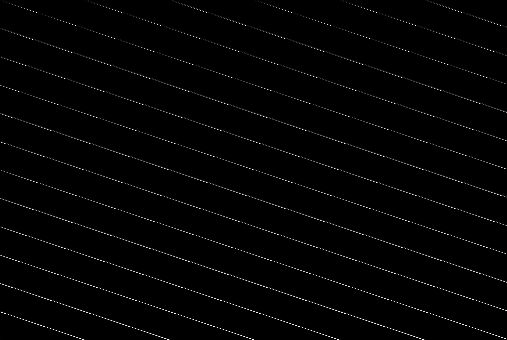

array([[2.2853725e-02, 1.7895924e-02, 2.4694888e-02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 9.7849108e-03,
        3.7322279e-05, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 9.4102246e-01,
        9.8530209e-01, 5.8080196e-02],
       [1.3891929e-02, 4.2849751e-05, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [ ]:
#Loading the YOLO model and classes
net = cv2.dnn.readNet("./drive/MyDrive/SIP_Project/yolov3-tiny.weights", "./drive/MyDrive/SIP_Project/yolov3-tiny.cfg")
classes = []
with open("./drive/MyDrive/SIP_Project/coco.names", "r") as f:
    classes = f.read().splitlines()

#Loading image and convert to blob(binary large object)
imgy = img_rgb.copy()
height, width,_ = imgy.shape
blob = cv2.dnn.blobFromImage(np.float32(imgy), 1/255, (416,416), (0,0,0), crop=False)

#Passing blob through network
net.setInput(blob)
output_layers_names = net.getUnconnectedOutLayersNames()
layerOutputs = net.forward(output_layers_names)

#Extract bounding boxes, confidences, and class IDs
boxes = []
confidences = []
class_ids = []
for output in layerOutputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * width)
            center_y = int(detection[0] * height)
            w = int(detection[0] * width)
            h = int(detection[0] * height)
            x = int(center_x - w/2)
            y = int(center_y - h/2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

#Applying non-maximum suppression
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

#Drawing bounding boxes and labels on image
colors = np.random.uniform(0, 255, size=(len(boxes), 3))
if len(indexes) > 0:
    for i in indexes.flatten():
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        confidence = confidences[i]
        color = colors[class_ids[i]]
        cv2.rectangle(imgy, (x,y), (x+w,y+h), color, 2)
        cv2.putText(imgy, label + ' ' + str(round(confidence,2)), (x,y+20), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255),2)

output=output.reshape(340,507)
cv2_imshow(output*255)
output

Resources:

1. https://pjreddie.com/darknet/yolo/

2. Stack Overflow

3. Edureka(YT)